# SECOM dataset

Dataset source in this <a href="https://archive.ics.uci.edu/ml/datasets/SECOM">link</a> 

**Data Set Information:**

The data consists of 2 files the dataset file SECOM consisting of 1567 examples each with 591 features a 1567 x 591 matrix and a labels file containing the classifications and date time stamp for each example.

**Prediction needed**

Create a model that predict (classifies) if a chip is manufactured corretly or faulty. Ideally, the lest faulty chips that are delivered to customers the better. 

**Model used**

For the predictions I used Random Forest, since this model is not sensitive to outliers and it does not requires much feature transformation. Additional, I used Boruta in order to reduce the amount of feaures used in the model

**Results**

For our final model results:

- `Accuracy = 0.91`
- `Precision = 0.18`
- `Recall = 0.31`

## Importing needed libraries

In [40]:
# Basic libraries for data manipulation & plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Split data
from sklearn.model_selection import train_test_split

# Feature selection with boruta
from boruta import BorutaPy

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# SMOTE: Imbalanced data
from imblearn.over_sampling import SMOTE

# Tomek Links
from imblearn.under_sampling import TomekLinks

# Predictions
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

## Importing the Secom dataset from the UCI Machine Learning Repository

In [2]:
#Importing the sensors data
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secom = pd.read_table(url, header=None, delim_whitespace=True)

In [3]:
#Renaming the variables
secom = secom.add_prefix('sensor_')

In [4]:
#Importing the target variable data
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
labels = pd.read_table(url, header=None, usecols=[0], squeeze=True, delim_whitespace=True)

In [5]:
#Merging both data with labels
df = pd.concat([secom, labels], axis=1)

In [6]:
#Rename target variable
df = df.rename(columns={0: "target_variable"})

In [7]:
#Replace Nan hard-coded with actualy Nan
df = df.replace('NaN', np.nan)

In [8]:
df.shape

(1567, 591)

In [9]:
df.head()

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_581,sensor_582,sensor_583,sensor_584,sensor_585,sensor_586,sensor_587,sensor_588,sensor_589,target_variable
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [10]:
#Class distribution
class_counts = df.groupby('target_variable').size()
print(class_counts)

target_variable
-1    1463
 1     104
dtype: int64


In [11]:
types = df.dtypes
print(types)

sensor_0           float64
sensor_1           float64
sensor_2           float64
sensor_3           float64
sensor_4           float64
                    ...   
sensor_586         float64
sensor_587         float64
sensor_588         float64
sensor_589         float64
target_variable      int64
Length: 591, dtype: object


# Data preprocessing

Since I am planning to use Random Forest, I will just check for missing values, since Random Forest is not senstive to outliers and non-transformed variables

### 1.1 Checking missing values

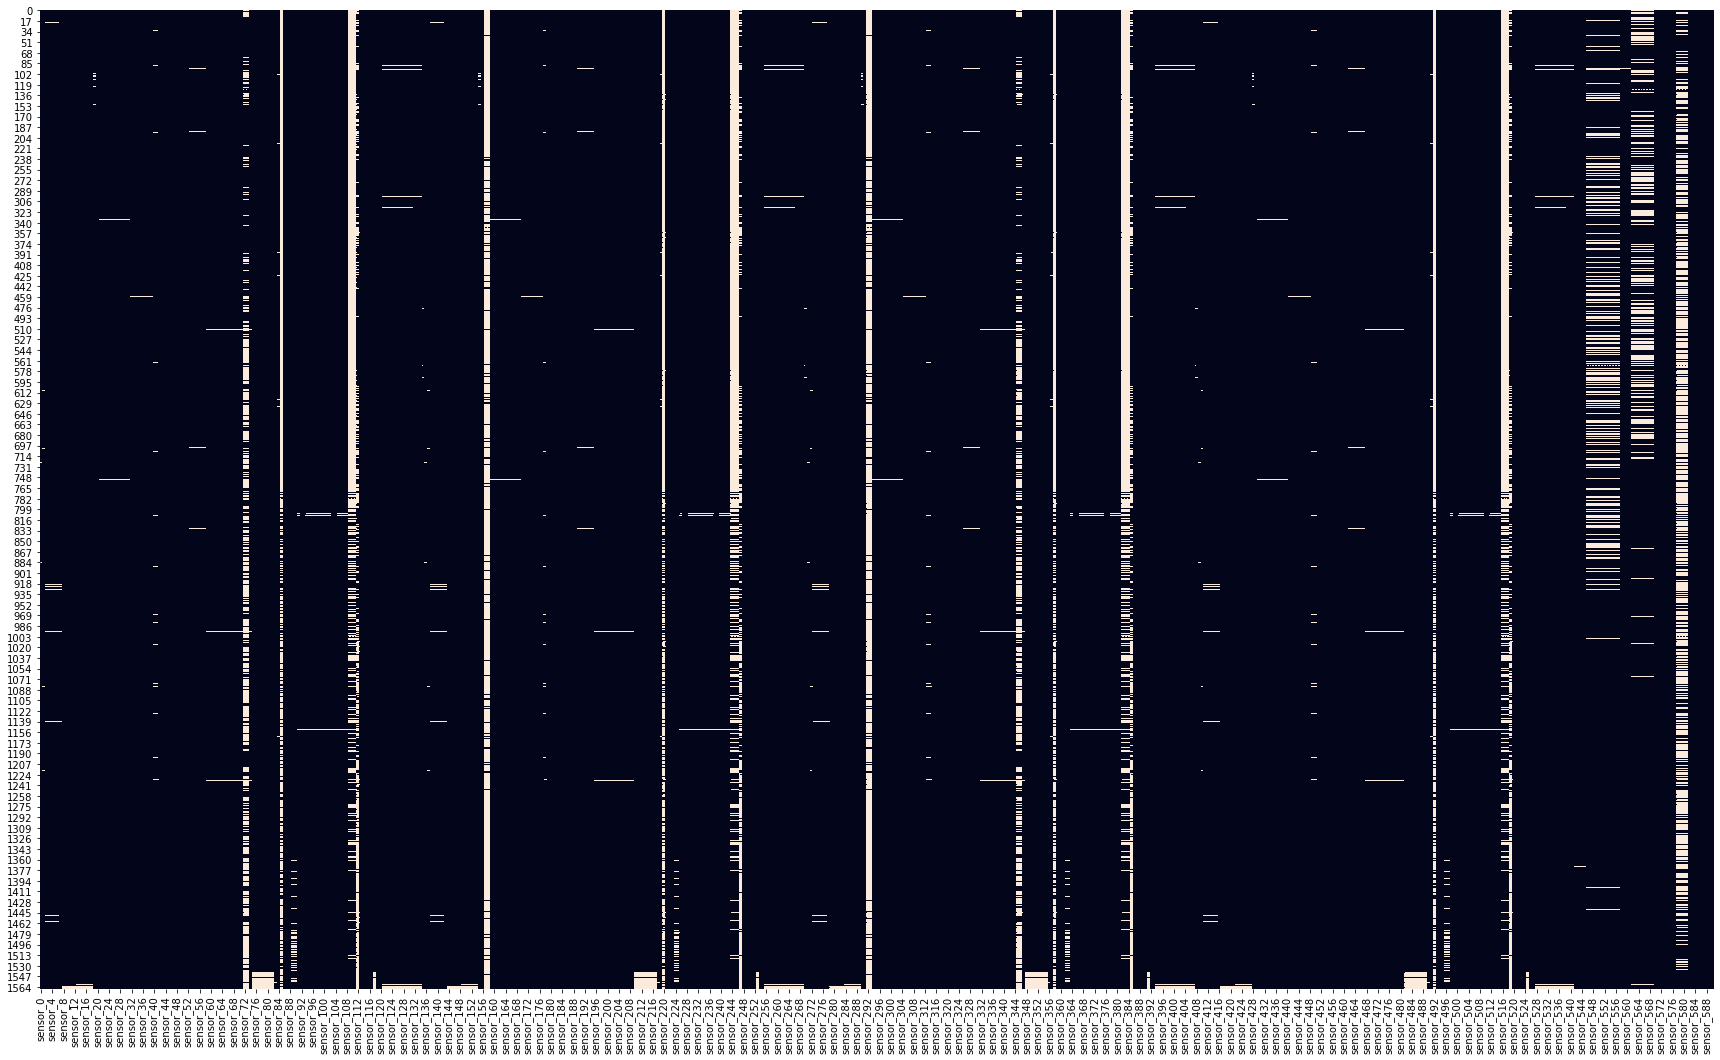

In [12]:
#Setting up plot size
plt.rcParams["figure.figsize"] = (30,18)

#Plotting variables with number of missing values
sns.heatmap(df.isnull(), cbar=False);

In [13]:
#Removing columns with a 15% of missing values (arbitrary %)
df_2 = df.loc[:, df.isnull().mean() <= .15]

In [14]:
df_2.shape

(1567, 539)

### 1.2. Data imputation (using mean)

In [15]:
# imputing missing values with just the mean
df_3 =  df_2.fillna(df_2.mean())

# Split into Train and Test Sets

In [16]:
X = df_3.drop(columns=['target_variable'], axis=1).values

In [17]:
Y = df_3.target_variable

In [18]:
test_size = 0.20

In [19]:
seed = 7

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size,
random_state=seed)

In [21]:
X_train.shape

(1253, 538)

# Feature selection with Boruta

In [22]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=500, oob_score=True, max_depth=6)

In [23]:
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

In [24]:
feat_selector.fit(X_train, Y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	538
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	538
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	538
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	538
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	538
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	538
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	538
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	16
Rejected: 	522
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	14
Rejected: 	522
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	14
Rejected: 	522
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	14
Rejected: 	522
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	13
Rejected: 	522
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	13
Rejected: 	522
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	13
Rejected: 	522
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	13
Rejected: 	522
Iteration: 	16 / 100
Confirmed: 	4
Tentat

BorutaPy(estimator=RandomForestClassifier(max_depth=6, n_estimators=91,
                                          n_jobs=-1, oob_score=True,
                                          random_state=RandomState(MT19937) at 0x7FD09510A340),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FD09510A340, verbose=2)

In [25]:
X_filtered = feat_selector.transform(X_train)

In [26]:
X_filtered.shape

(1253, 12)

In [27]:
features = [f for f in df_3.columns if f not in ['target_variable']]
len(features)

538

In [28]:
final_features = list()
indexes = np.where(feat_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(features[x])
print(final_features)

['sensor_38', 'sensor_40', 'sensor_59', 'sensor_64', 'sensor_65', 'sensor_153', 'sensor_267', 'sensor_348', 'sensor_426', 'sensor_441', 'sensor_477', 'sensor_539']


In [29]:
X_test = feat_selector.transform(X_test)

In [30]:
X_test.shape

(314, 12)

# Imbalacened dataset

In [31]:
smote = SMOTE(sampling_strategy=0.9, random_state=42)

In [32]:
X_sm, y_sm = smote.fit_resample(X_filtered, Y_train)

In [33]:
print(f'''Shape of X before SMOTE: {X_filtered.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (1253, 12)
Shape of X after SMOTE: (2207, 12)

Balance of positive and negative classes (%):


-1    52.650657
 1    47.349343
Name: target_variable, dtype: float64

# Predictions

In [34]:
model = RandomForestClassifier(random_state=42)
model.fit(X_sm, y_sm)

RandomForestClassifier(random_state=42)

In [35]:
preds = model.predict(X_test)

Accuracy = 0.91
Precision = 0.17
Recall = 0.31



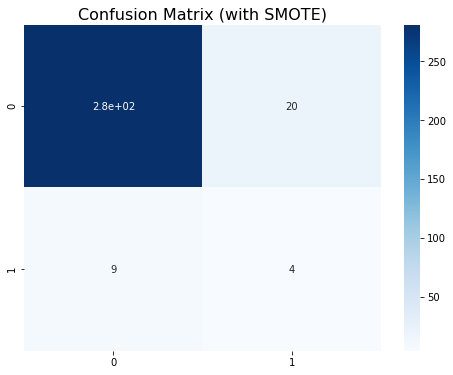

In [39]:
print(f'Accuracy = {accuracy_score(Y_test, preds):.2f}\nPrecision = {precision_score(Y_test, preds):.2f}\nRecall = {recall_score(Y_test, preds):.2f}\n')
cm = confusion_matrix(Y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

# Predictions with Tomek Links to improve Recall 

In [43]:
tl = TomekLinks()

In [44]:
X_tl, y_tl = tl.fit_resample(X_sm, y_sm)

In [46]:
print(f'''Shape of X before Tomek Link: {X_sm.shape}
Shape of X after Tomek link: {X_tl.shape}''')

print('\nBalance of positive and negative classes (%):')
y_tl.value_counts(normalize=True) * 100

Shape of X before Tomek Link: (2207, 12)
Shape of X after Tomek link: (2194, 12)

Balance of positive and negative classes (%):


-1    52.3701
 1    47.6299
Name: target_variable, dtype: float64

In [47]:
model = RandomForestClassifier(random_state=42)
model.fit(X_tl, y_tl)

RandomForestClassifier(random_state=42)

In [48]:
preds = model.predict(X_test)

Accuracy = 0.91
Precision = 0.18
Recall = 0.31



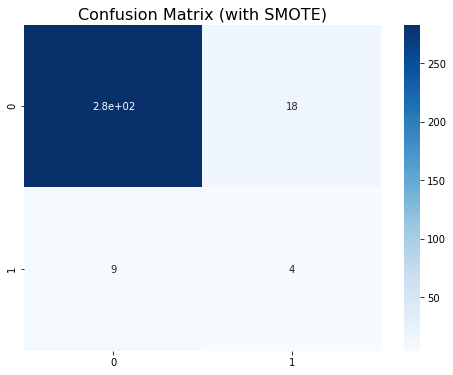

In [49]:
print(f'Accuracy = {accuracy_score(Y_test, preds):.2f}\nPrecision = {precision_score(Y_test, preds):.2f}\nRecall = {recall_score(Y_test, preds):.2f}\n')
cm = confusion_matrix(Y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');